In [1]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import glob, operator, time, shutil, scipy, sys, sklearn
import pandas as pd
from sklearn.manifold import TSNE
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter

pd.set_option('display.max_columns', 100)
plt.style.use('classic')

In [2]:
def new_fig(figsize=(8.9, 5)):
    plt.close()
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(3)    
    ax1.yaxis.grid(linestyle='--')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for line in ax1.get_xticklines() + ax1.get_yticklines():
        line.set_markersize(8)
    return ax1

In [22]:
df18 = pd.read_csv('../data/autoperf_complete/ANL-ALCF-AUTOPERF-MIRA_20180101_20181231.csv')
# df18 = pd.read_csv('data/ANL-ALCF-AUTOPERF-MIRA_20180101_20181231.csv')
df18.head(3)

MACHINE_NAME  RUN_DATE_ID  MPI_MPI_BSEND_INIT_TOTALCYCLES  \
0         mira     20180101                               0   
1         mira     20180101                               0   
2         mira     20180101                               0   

   MPI_MPI_ALLTOALL_TOTALTIME  MPI_MPI_IBSEND_TOTALBYTES  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   

   MPI_MPI_ALLGATHERV_TOTALBYTES  MPI_MPI_SSEND_TOTALCYCLES  \
0                            0.0                          0   
1                            0.0                          0   
2                            0.0                          0   

   MPI_MPI_GATHERV_CALLCOUNT  MPI_MPI_SCAN_CALLCOUNT  \
0                          0                       0   
1                          0                       0   
2                          0                       0   

   MPI_MPI_IRECV_TOTALBYTES  MPI_MPI_SCAN_TOTALCYCLES  HPM_PLASTINDEX  \
0              3.685553e+10                         0               5   
1              7.449665e+10                         0               5   
2              6.532547e+10                         0               5   

   MPI_MPI_BSEND_INIT_TOTALTIME  SYS_CORESPERNODE  \
0                           0.0                16   
1                           0.0                16   
2                           0.0                16   

   MPI_MPI_SEND_INIT_TOTALTIME  MPI_MPI_ALLTOALLV_TOTALBYTES  MPI_VERSION  \
0                          0.0                           0.0            1   
1                          0.0                           0.0            1   
2                          0.0                           0.0            1   

   MPI_MPI_TESTANY_TOTALCYCLES  MPI_MPI_PROBE_TOTALTIME  \
0                            0                      0.0   
1                            0                      0.0   
2                            0                      0.0   

   MPI_MPI_ISSEND_CALLCOUNT  HPM_PFIRSTINDEX  MPI_MPI_BCAST_TOTALTIME  \
0                         0                0                81.091612   
1                         0                0                 7.474766   
2                         0                0                57.039748   

   MPI_MPI_REDUCE_SCATTER_TOTALCYCLES  SYS_VERSION  PROC_VERSION  \
0                                   0            1             1   
1                                   0            1             1   
2                                   0            1             1   

   PROC_ELAPSEDCYCLES  MPI_MPI_IBSEND_CALLCOUNT  MPI_MPI_BCAST_TOTALBYTES  \
0      67418999396218                         0                   55308.0   
1      67432475273838                         0                   52912.0   
2      67439854841154                         0                   52368.0   

   MPI_MPI_SSEND_INIT_CALLCOUNT  MPI_MPI_EXSCAN_TOTALTIME  MPI_MYRANK  \
0                             0                       0.0         199   
1                             0                       0.0           0   
2                             0                       0.0         112   

   PROC_EXECNAME_GENID  MPI_MPI_ALLTOALLW_TOTALTIME  \
0       33102499196819                          0.0   
1       33102499196819                          0.0   
2       33102499196819                          0.0   

   MPI_MPI_TESTSOME_CALLCOUNT  MPI_MPI_STARTALL_CALLCOUNT     MPI_THREADMODE  \
0                           0                           0  MPI_THREAD_SINGLE   
1                           0                           0  MPI_THREAD_SINGLE   
2                           0                           0  MPI_THREAD_SINGLE   

   HPM_PEVT_LSU_COMMIT_LD_MISSES  MPI_MPI_BUFFER_DETACH_CALLCOUNT  \
0                   102005725730                                0   
1                   111395260489                                0   
2                   119206069103                             

In [16]:
# for k in df18.columns:
#     if 'MPI' not in k:print(k)

# load store unit

In [17]:
# lsu_miss = 100. * ap_raw_1808.zero_PEVT_LSU_COMMIT_LD_MISSES / ap_raw_1808.zero_PEVT_LSU_COMMIT_CACHEABLE_LDS

In [18]:
gflops, gops, opf, opc = np.array([]), np.array([]), np.array([]), np.array([])
ram_fetch_bps, ram_store_bps, ram_fetch_bpop, ram_store_bpop = np.array([]), np.array([]), np.array([]), np.array([])
for fn in glob.glob('data/autoperf-*')[:]:
    data_df = pd.read_csv(fn)
    _gflops = 1e-9 * (data_df.av_PEVT_INST_QFPU_ALL / data_df.av_elapsedTime * data_df.av_numProcessesOnNode).values
    gflops = np.append(_gflops[~np.isnan(_gflops)], gflops)

    _ops = 1e-9 * ((data_df.av_PEVT_INST_XU_ALL + data_df.av_PEVT_INST_QFPU_ALL) / data_df.av_elapsedTime * data_df.av_numProcessesOnNode).values
    gops = np.append(_ops[~np.isnan(_ops)], gops)
    
    _opc = ((data_df.av_PEVT_INST_XU_ALL + data_df.av_PEVT_INST_QFPU_ALL) / data_df.av_elapsedCycles * data_df.av_numProcessesOnNode).values
    opc = np.append(_opc[~np.isnan(_opc)], opc)
    
    _opf  = data_df.av_PEVT_INST_XU_ALL / data_df.av_PEVT_INST_QFPU_ALL
    opf   = np.append(_opf[~np.isnan(_opf)], opf)
    
    _ram_fetch_bps = (data_df.av_PEVT_L2_FETCH_LINE * 128 / data_df.av_elapsedTime) * data_df.av_numProcessesOnNode
    ram_fetch_bps  = np.append(ram_fetch_bps, _ram_fetch_bps[~np.isnan(_ram_fetch_bps)])
    
    _ram_store_bps = (data_df.av_PEVT_L2_STORE_LINE * 128 / data_df.av_elapsedTime) * data_df.av_numProcessesOnNode
    ram_store_bps  = np.append(ram_store_bps, _ram_store_bps[~np.isnan(_ram_store_bps)])
    
    _ram_fetch_bpop = (data_df.av_PEVT_L2_FETCH_LINE * 128 / (data_df.av_PEVT_INST_QFPU_ALL + data_df.av_PEVT_INST_XU_ALL)) * data_df.av_numProcessesOnNode
    ram_fetch_bpop  = np.append(ram_fetch_bpop, _ram_fetch_bpop[~np.isnan(_ram_fetch_bpop)])
    
    _ram_store_bpop = (data_df.av_PEVT_L2_STORE_LINE * 128 / (data_df.av_PEVT_INST_QFPU_ALL + data_df.av_PEVT_INST_XU_ALL)) * data_df.av_numProcessesOnNode
    ram_store_bpop  = np.append(ram_store_bpop, _ram_store_bpop[~np.isnan(_ram_store_bpop)])
    

/home/luckierdodge/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


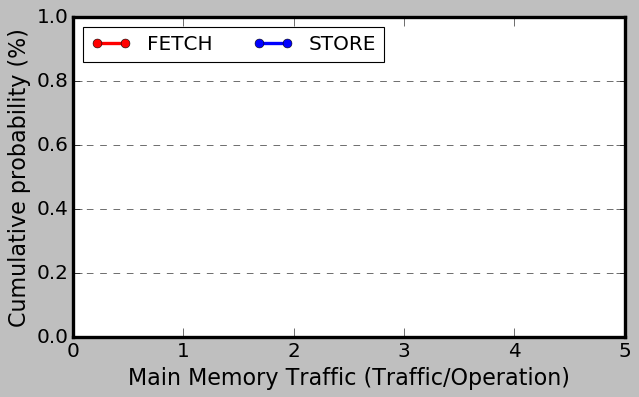

/home/luckierdodge/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


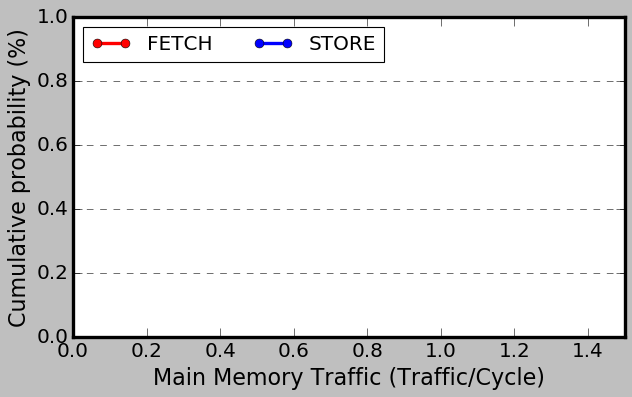

In [19]:
def plot_ram_rate(datas, labels, nbins=20, dmin=15, dmax=42, xlabel=None, ofn=None, is_xt = False):
    ax = new_fig()
    colors = ['r', 'b']
    for idx, data in enumerate(datas):
        bins = np.linspace(dmin, dmax, nbins)
        cnt  = [data[data<bf].shape[0] for bf in bins]
        norm = np.array(cnt) / data.shape[0] * 100
        plt.plot(bins, norm, '-o', linewidth=3, markersize=8, color=colors[idx], label=labels[idx])
#         plt.fill_between(bins, norm, color=colors[idx], alpha=.2)

    plt.ylabel('Cumulative probability (%)', fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.xlim(left=dmin, right=dmax)
    if is_xt: plt.xticks(range(dmin, dmax, 2), [r'$2^{%d}$' % (p) for p in range(dmin, dmax, 2)], fontsize=20)
    plt.legend(ncol=2, loc=2, fontsize=18)
    
    if ofn is not None:
        plt.savefig('../figure/'+ofn, bbox_inches='tight')
    plt.show()
        
    
# plot_ram_rate((np.log2(ram_fetch_bps), np.log2(ram_store_bps)), nbins=20, dmin=18, dmax=41, \
#               labels=('FETCH', 'STORE'), xlabel='Main Memory Traffic (Bytes/Second)', ofn='ram-bps.pdf', is_xt=True)

# plot_ram_rate((np.log2(ram_fetch_bpop), np.log2(ram_store_bpop)), nbins=30, dmin=0, dmax=11, \
#               labels=('FETCH', 'STORE'), xlabel='Main Memory Throughput (Bytes/Operation)', ofn='ram-bpop.pdf', is_xt=True)

plot_ram_rate((ram_fetch_bpop/128, ram_store_bpop/128), nbins=30, dmin=0, dmax=5, \
              labels=('FETCH', 'STORE'), xlabel='Main Memory Traffic (Traffic/Operation)', ofn='ram-tpop.pdf', is_xt=False)

plot_ram_rate((ram_fetch_bps/128/1.6e9, ram_store_bps/128/1.6e9), nbins=30, dmin=0, dmax=1.5, \
              labels=('FETCH', 'STORE'), xlabel='Main Memory Traffic (Traffic/Cycle)', ofn='ram-tpc.pdf', is_xt=False)

/home/luckierdodge/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


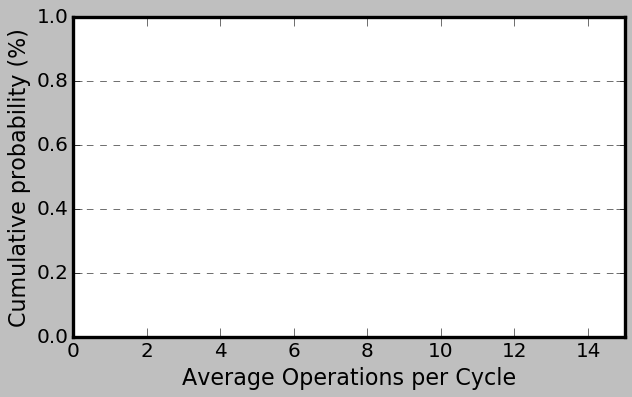

In [21]:
def plot_cdf_single(data, nbins=15, dmax=20, xlabel=None, ofn=None):    
    bins = np.linspace(0, dmax, 20)
    cnt  = [data[data<bf].shape[0] for bf in bins]
    norm = np.array(cnt) / data.shape[0] * 100
        
    ax = new_fig()
    plt.plot(bins, norm, '-o', linewidth=4, markersize=8, color='gray')
#     plt.fill_between(bins, norm, color='gold', alpha=.3)
    plt.ylabel('Cumulative probability (%)', fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.xlim(left=0, right=bins[-1])
#     plt.xticks(range(0, 11), [r'%d' % (p) for p in range(0, 11)], fontsize=20)
    
    if ofn is not None:
        plt.savefig('../figure/'+ofn, bbox_inches='tight')
    plt.show()
        
# plot_cdf_single(gflops, dmax=7, xlabel='Average GigaFLOPS per node', ofn='gflops.pdf')
# plot_cdf_single(gops, dmax=22, xlabel='Average GigaOPS per node', ofn='gops.pdf')

plot_cdf_single(opc, dmax=15, xlabel='Average Operations per Cycle', ofn='gopc.pdf')

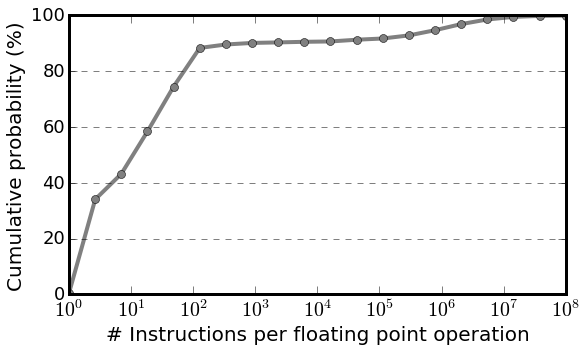

In [9]:
def plot_cdf_ipf(data, nbins=15, dmax=20, ofn=None):    
    bins = np.linspace(0, dmax, 20)
    cnt  = [data[data<bf].shape[0] for bf in bins]
    norm = np.array(cnt) / data.shape[0] * 100
        
    ax = new_fig()
    plt.plot(bins, norm, '-o', linewidth=4, markersize=8, color='gray')
#     plt.fill_between(bins, norm, color='gold', alpha=.3)
    plt.ylabel('Cumulative probability (%)', fontsize=20)
    plt.xlabel('# Instructions per floating point operation', fontsize=20)
    plt.xlim(left=0, right=bins[-1])
    plt.xticks(range(0, dmax+1), [r'$10^{%d}$' % (p) for p in range(0, dmax+1)], fontsize=20)
    
    if ofn is not None:
        plt.savefig('figure/'+ofn, bbox_inches='tight')
    plt.show()
    
plot_cdf_ipf(np.log10(opf), dmax=8, ofn='instruction-per-flop.pdf')

# log summary 

In [27]:
node_hours, n_tasks = 0, 0
for fn in glob.glob('../data/autoperf_complete/autoperf-*')[:]:
#     print(fn)
    _pdf = pd.read_csv(fn)
    _nodes = (_pdf.zero_numRanks / _pdf.zero_numProcessesOnNode).values
    _mask  = ~np.isnan(_nodes)
    _nodes = _nodes[_mask]
    node_hours += (_pdf.av_elapsedTime[_mask] / 3600. * _nodes).sum()
    print('for logs in %s, %d log(s) are ignored because of nan' % (fn.split('/')[-1], _mask.shape[0] - _mask.sum()))
    n_tasks += _mask.sum()
    
print("core hours of {:,} tasks is {:,.2f} ".format(n_tasks, node_hours))

for logs in autoperf-2016-3.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2016-10.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2015-11.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2018-8.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2017-3.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2016-6.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2017-5.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2018-10.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2018-1.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2016-11.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2016-1.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2017-10.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2017-8.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2019-1.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2018-6.c

In [30]:
_pdf = pd.read_csv('../data/autoperf_complete/autoperf-2018-4.csv')

# visualize characters using T-SNE

In [33]:
def extrac_job_feature(fns):
    fname  = ('mpi_time', 'mpiio_time', 'OPS', 'FLOPS', 'ppn', 'ram_fetch', 'ram_store', 'exec_name')
    rvalue = np.zeros(shape=(0, len(fname)))
    exe_name, user_name = [], []
    
    for fn in fns:
        _pdf  = pd.read_csv(fn)
        _cycles   = _pdf.av_elapsedCycles
        _eps_time = _pdf.av_elapsedTime
        _feat = np.c_[_pdf.av_stdMpiTime/_eps_time, _pdf.av_mpiIoTime/_eps_time, _pdf.av_PEVT_INST_XU_ALL/_cycles, \
                      _pdf.av_PEVT_INST_QFPU_ALL/_cycles, _pdf.av_numProcessesOnNode, \
                      _pdf.av_PEVT_L2_FETCH_LINE / _cycles, _pdf.av_PEVT_L2_STORE_LINE / _cycles]
        _nan_mask = ~np.isnan(_feat).any(axis=1)
        _feat = _feat[_nan_mask] # remove rows with nan
        _exec_name = _pdf.zero_execName.values[_nan_mask]
        _feat  = np.append(_feat, np.expand_dims(_exec_name, 1), axis=1)
        
        exe_name += _pdf.zero_execName.values[_nan_mask].tolist()
        user_name += _pdf.zero_userName.values[_nan_mask].tolist()
        rvalue = np.append(rvalue, _feat, axis=0)
    return pd.DataFrame(rvalue, columns=fname), np.array(exe_name), np.array(user_name)

task_feature, exe_name, user_name = extrac_job_feature(glob.glob('../data/autoperf_complete/autoperf-*')[:])
task_feature.to_pickle("../data/task-fingerprint.pkl")
task_feature.shape, exe_name.shape, user_name.shape

/home/luckierdodge/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (58,269,270,295,506,507,532,743,744,769) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


((77465, 8), (77465,), (77465,))

In [34]:
pca_obj = sklearn.decomposition.PCA(n_components=2)
pca_obj.fit(task_feature.values[:, :-1])
print('explained variance ratio (first two components): %s'
      % str(pca_obj.explained_variance_ratio_))
pca_red = pca_obj.transform(task_feature.values[:, :-1])

explained variance ratio (first two components): [0.97228096 0.02501337]


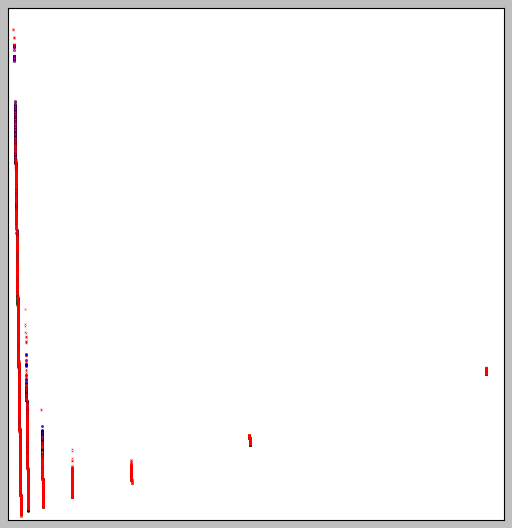

In [35]:
def pca_vis_by_group(x_emb, exe_idn, topn=10, ofn=None):
    idn_unique, idn_count = np.unique(exe_idn, return_counts=True)
    top_idn = idn_unique[np.argsort(idn_count)[-topn:]]
    plt.figure(figsize=(8, 8))
    colors = ('g', 'b', 'gold', 'yellow', 'tan', 'cyan', 'magenta', 'black', 'orange', 'darkgreen')
    _other_grp = np.zeros(exe_idn.shape[0], dtype=np.bool)
    for _idx, _idn in enumerate(top_idn):
        _emb_grp = x_emb[exe_idn == _idn]
        plt.plot(_emb_grp[:, 0], _emb_grp[:, 1], 'o', alpha=.8, color=colors[_idx], markersize=2, label = _idn)
        _other_grp |= (exe_idn == _idn)
        
    _uncat = x_emb[~_other_grp]
    plt.plot(_uncat[:, 0], _uncat[:, 1], 'x', alpha=.8, color='r', markersize=1.5, label = 'Uncat')
    
    plt.xlim(left=x_emb[:, 0].min()*1.05, right=x_emb[:, 0].max()*1.05)
    plt.ylim(bottom=x_emb[:, 1].min()*1.05, top=x_emb[:, 1].max()*1.05)
    plt.xticks([])
    plt.yticks([])
#     plt.legend(ncol=4, loc=2, fancybox=False, framealpha=0.5)
    if ofn is not None:
        plt.savefig('figure/' + ofn, bbox_inches='tight', quality=99, dpi=300)
    plt.show()
    plt.close()
    
pca_vis_by_group(pca_red, task_feature.exec_name.values, )

In [36]:
task_feature.shape

(77465, 8)

In [37]:
tsne_obj = TSNE(n_components=2, random_state=2019)
X_embedded = tsne_obj.fit_transform(preprocessing.scale(task_feature.values[:45000, :-1]))
X_embedded.shape, tsne_obj.kl_divergence_, tsne_obj.n_iter_

((45000, 2), 1.2306838035583496, 999)

In [38]:
task_feature.head()

mpi_time mpiio_time       OPS      FLOPS ppn  ram_fetch  ram_store  \
0  0.187961          0     0.101  0.0303617  64   0.047383  0.0304823   
1  0.182331          0  0.101819  0.0307774  64  0.0477458   0.030884   
2  0.182387          0  0.100873  0.0307198  64  0.0476245  0.0307928   
3  0.177487          0  0.103002  0.0310193  64  0.0476461  0.0311141   
4  0.179721          0  0.103567  0.0308082  64  0.0471258  0.0308196   

  exec_name  
0   nek5000  
1   nek5000  
2   nek5000  
3   nek5000  
4   nek5000

pp_d9bc7f7d7bde628bdb5b1332c10cfca9b2353baa-parallel-IRP-2016-05-20.x is marked by g and x
pw_345843b10ded2b35bdf293a8220dbc63f28b2a1a-prod-2016-05-18.x is marked by b and o
bigdft is marked by gold and >
aims.180111.scalapack.mpi.x is marked by yellow and <
cesm.exe is marked by tan and s
qmcpack is marked by cyan and v
IOR is marked by magenta and H
mcfm_omp is marked by black and D
nek5000 is marked by orange and 3
goldfish is marked by darkgreen and 1


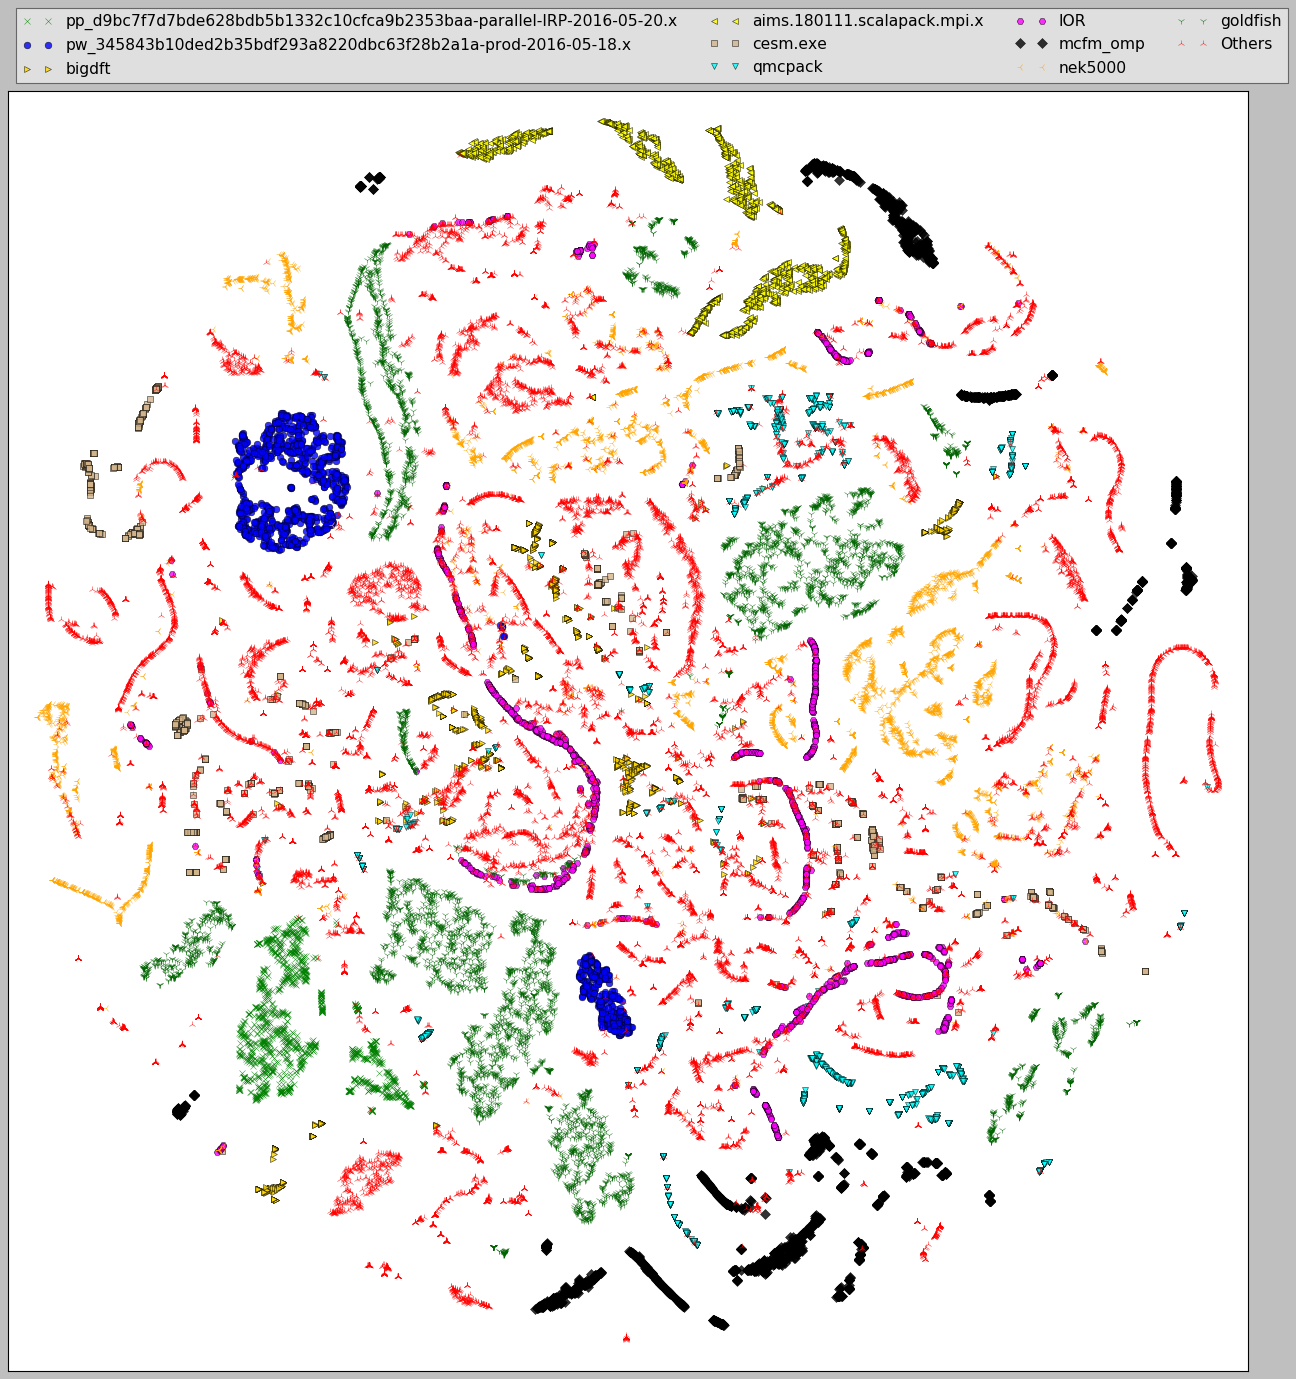

In [39]:
def t_sne_vis_by_group(x_emb, exe_idn, topn=3, ofn=None):
    idn_unique, idn_count = np.unique(exe_idn, return_counts=True)
    top_idn = idn_unique[np.argsort(idn_count)[-topn:]]
    plt.figure(figsize=(20, 20))
    colors = ('g', 'b', 'gold', 'yellow', 'tan', 'cyan', 'magenta', 'black', 'orange', 'darkgreen')
    markers= ('x', 'o', '>', '<', 's', 'v', 'H', 'D', '3', '1', '2')
    _other_grp = np.zeros(exe_idn.shape[0], dtype=np.bool)
    for _idx, _idn in enumerate(top_idn):
        _emb_grp = x_emb[exe_idn == _idn]
        plt.plot(_emb_grp[:, 0], _emb_grp[:, 1], markers[_idx], alpha=.8, color=colors[_idx], markersize=6, label = _idn[:])
        _other_grp |= (exe_idn == _idn)
        print("%s is marked by %s and %s" % (_idn, colors[_idx], markers[_idx]))
    _uncat = x_emb[~_other_grp]
    plt.plot(_uncat[:, 0], _uncat[:, 1], markers[-1], alpha=.8, color='r', markersize=6, label = 'Others')
    
    plt.xlim(left=X_embedded[:, 0].min()*1.05, right=X_embedded[:, 0].max()*1.05)
    plt.ylim(bottom=X_embedded[:, 1].min()*1.05, top=X_embedded[:, 1].max()*1.05)
    plt.xticks([])
    plt.yticks([])
    plt.legend(bbox_to_anchor=(0., 1.0, 1., .102), ncol=4, loc=3, fancybox=False, framealpha=0.5, fontsize=14)
    if ofn is not None:
        plt.savefig('../figure/' + ofn, bbox_inches='tight', quality=99, dpi=300)
    plt.show()
    plt.close()
#     print(top_idn)
# t_sne_vis_by_group(X_embedded, user_name, topn=10, ofn='tsne-username.png')
t_sne_vis_by_group(X_embedded, task_feature.values[:45000, -1], topn=10, ofn='tsne-exename.png')

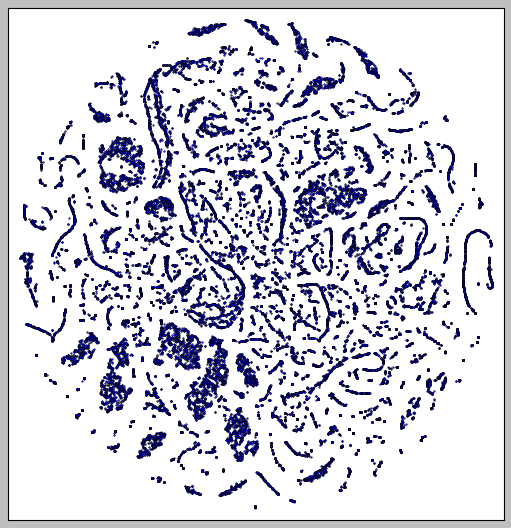

In [40]:
# ax = new_fig(figsize=(8, 8))
plt.figure(figsize=(8, 8))
plt.plot(X_embedded[:, 0], X_embedded[:, 1], 'o', alpha=.8, color='b', markersize=1.5)
# plt.axis('off')
# plt.xlabel('t-SNE Dimension 1', fontsize=18)
# plt.ylabel('t-SNE Dimension 2', fontsize=18)
plt.xlim(left=X_embedded[:, 0].min()*1.05, right=X_embedded[:, 0].max()*1.05)
plt.ylim(bottom=X_embedded[:, 1].min()*1.05, top=X_embedded[:, 1].max()*1.05)
plt.xticks([])
plt.yticks([])
plt.savefig('../figure/task-t-sne.png', bbox_inches='tight', quality=99, dpi=300)
plt.show()
plt.close()

In [43]:
pdf_test = pd.read_csv('../data/autoperf_complete/autoperf-2018-8.csv')

In [44]:
topn = 10
idn_unique, idn_count = np.unique(exe_name, return_counts=True)
idn_unique[np.argsort(idn_count)[-topn:]]

array(['vasp.bgq', 'bigdft', 'cesm.exe', 'mpcf-cluster', 'HACC_IO',
       'qmcpack', 'mcfm_omp', 'IOR', 'goldfish', 'nek5000'], dtype='<U98')

In [45]:
exe_names_rank = pd.read_csv('../data/autoperf_complete/autoperf-2018-8.csv').zero_execName.value_counts()

In [46]:
exe_names = {}
for fn in glob.glob('data/autoperf-*')[:]:
    _pdf = pd.read_csv(fn)
    exe_rank = _pdf.zero_execName.value_counts()
    for exe in exe_rank.keys():
        if not isinstance(exe, str): continue
        if exe_names.get(exe) is None:
            exe_names[exe] = exe_rank[exe]
        else:
            exe_names[exe] += exe_rank[exe]
#         if 'hacc' in exe.lower(): print(exe)

In [47]:
names = np.array(list(exe_names.keys()))
vals  = np.array(list(exe_names.values()))
n_jobs= np.sum(vals)
with open('exe-name-rank.txt', 'w') as fd:
    fd.write('name,freq\n')
    for idx in np.argsort(vals)[::-1]:
        fd.write('%s,%.4f\n' % (names[idx], 100.*vals[idx]/n_jobs))

ValueError: shape mismatch: objects cannot be broadcast to a single shape

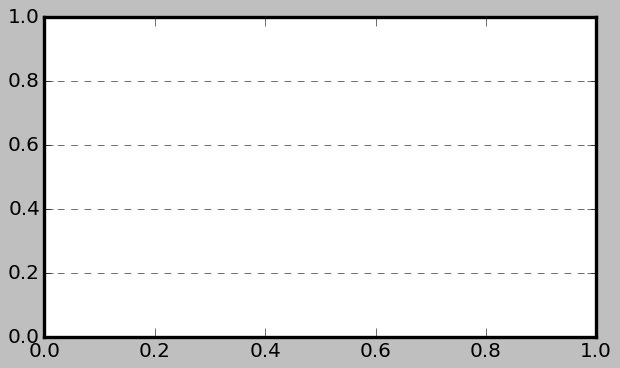

In [49]:
def plot_exe_name_grp(topN, ofn=None):
    _pdf = pd.read_csv('exe-name-rank.txt')
    ax = new_fig()
    width = .7
    plt.bar(range(topN), _pdf.freq[:topN], align='center', 
            width=width, color='gray', alpha=.7, hatch='x')
    
    plt.xlim(left=-width, right=topN)
    plt.xlabel('Top %d executable names' % topN, fontsize=18)
    plt.xticks([], [])
    plt.ylabel('Frequency [%]', fontsize=18)
    if ofn is not None:
        plt.savefig('../figure/' + ofn, bbox_inch='tight')
        
plot_exe_name_grp(20, ofn='exename-freq.pdf')

In [50]:
# get user to exetable name map
username2exename = {}
for fn in glob.glob('../data/autoperf_complete/autoperf-*')[:]:
    _pdf = pd.read_csv(fn)
    for u, e in _pdf[['zero_userName', 'zero_execName']].values:
        if username2exename.get(u) is None:
            username2exename[u] = set()
        username2exename[u].add(e)
        
with open('username2exename.txt', 'w') as rd:
    for u in username2exename.keys():
        rd.write("{}:{}\n".format(u, username2exename[u]))

/home/luckierdodge/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (58,269,270,295,506,507,532,743,744,769) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
# compute number of tasks using the difference between max and min of CS ID
min_cs_jid, max_cs_jid, total_jids = np.inf, 0, 0
for fn in glob.glob('../data/autoperf_complete/autoperf-*')[1:]:
    _pdf = pd.read_csv(fn)
    total_jids += _pdf.shape[0]
    min_cs_jid = min(min_cs_jid, _pdf.zero_csJobId.min())
    max_cs_jid = max(max_cs_jid, _pdf.zero_csJobId.max())

print("There should be at least {:,.0f} tasks, but only {:,} are logged, {:.2f}%%".format(\
      max_cs_jid-min_cs_jid, total_jids, 100.*total_jids/(max_cs_jid-min_cs_jid)))

There should be at least 1,958,485 tasks, but only 71,985 are logged, 3.68%%


# try to classify application by name

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from os.path import basename

In [77]:
def extrac_job_feature(filename):
    fname = ['REQUESTED_CORE_HOURS']
    exe_name, user_name = [], []

    _pdf = pd.read_csv(filename, header=0).sample(frac=1).iloc[0:5000].dropna()
    _pdf['EXEC_NAME'] = _pdf['COMMAND'].apply(basename)
    _feat = np.array(_pdf.REQUESTED_CORE_HOURS)
    
    
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    
    # One-hot Encode User Name
    user_feature = label_encoder.fit_transform(_pdf.USERNAME)
    user_feature = user_feature.reshape(len(_pdf.index), 1)
    user_feature = onehot_encoder.fit_transform(user_feature)
    # One-hot Encode Project Name
    project_feature = label_encoder.fit_transform(_pdf.PROJECT_NAME)
    project_feature = project_feature.reshape(len(_pdf.index), 1)
    project_feature = onehot_encoder.fit_transform(project_feature)
    # One-hot Encode Queue Name
    queue_feature = label_encoder.fit_transform(_pdf.QUEUE_NAME)
    queue_feature = queue_feature.reshape(len(_pdf.index), 1)
    queue_feature = onehot_encoder.fit_transform(queue_feature)
    # One-hot Encode Submission Time

    _feat = np.c_[_feat, user_feature, project_feature, queue_feature]
    _nan_mask = ~np.isnan(_feat).any(axis=1)
    _feat = _feat[_nan_mask] # remove rows with nan
    _exec_name = _pdf.EXEC_NAME.values[_nan_mask]
    _feat  = np.append(_feat, np.expand_dims(_exec_name, 1), axis=1)
    
    # Add feature name columns
    [fname.append("user." + username) for username in _pdf.USERNAME.unique()]
    [fname.append("project." + project) for project in _pdf.PROJECT_NAME.unique()]
    [fname.append("queue." + queue) for queue in _pdf.QUEUE_NAME.unique()]
    fname.append('exec_name')
    
    rvalue = np.zeros(shape=(0, len(fname)))
    exe_name += _pdf.EXEC_NAME.values[_nan_mask].tolist()
    user_name += _pdf.USERNAME.values[_nan_mask].tolist()
    rvalue = np.append(rvalue, _feat, axis=0)
    return pd.DataFrame(rvalue, columns=fname), np.array(exe_name), np.array(user_name)

task_feature, exe_name, user_name = extrac_job_feature('../data/mira_djc_complete/dim_job_composite.csv')
# task_feature.to_pickle("../data/task-fingerprint.pkl")
task_feature.shape, exe_name.shape, user_name.shape

((4983, 928), (4983,), (4983,))

In [78]:
def data_preprocess(feat_df, topn=10):
    tops_labels = feat_df.exec_name.value_counts()[:topn].keys()
    print("top {} executables are: {}".format(topn, tops_labels))
    exec_name2id = {}
    for i, x in enumerate(tops_labels):
        exec_name2id[x] = i
    exec_name2id['others'] = topn
    
    ret_df = feat_df.copy(deep=True) # make a copy
    enc = np.zeros(feat_df.shape[0], dtype=np.int8)
    for i, x in enumerate(feat_df.exec_name.values):
        _enc = exec_name2id.get(x)
        if _enc is None: _enc = exec_name2id['others']
        enc[i] = _enc
        
    ret_df['exec_name'] = enc
    X, Y = ret_df[ret_df.columns[:-1]].astype(np.float), ret_df[ret_df.columns[-1:]].astype(np.int8)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2019)
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = data_preprocess(task_feature, topn=20)

top 20 executables are: Index(['nek5000', 'qhmc', 'mcfm_omp', 'run.mira', 'run.512',
       'himd6416_4lat.csh', 'run-512.sh', 'qmcpack', 'phasta.sh', 'script.sh',
       'anl-run.sh', 'cp2k.psmp', 'flash4', 'myscript.sh', 'run.sh',
       'alpgenCombo.sh', 'aims.071914_7.scalapack.mpi.x', 'my-run.csh',
       'run.2048', 'hacc_pm'],
      dtype='object')


In [79]:
# for i in range(y_train.exec_name.unique().shape[0]):
#     print("{}: {:,.2f}".format(i, 100.*(y_train.exec_name==i).sum()/y_train.shape[0]))

In [80]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=2019, max_depth=10)
xgb_model.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=2019, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [81]:
y_pred = xgb_model.predict(X_test)
y_true = y_test.values.ravel()

In [82]:
metrics.accuracy_score(y_true, y_pred), metrics.f1_score(y_true, y_pred, average='macro')

(0.9264214046822743, 0.8538062249935986)

In [83]:
# percentage of mistake in "other" category, they are "other" but the classifier failed to catch
(y_true[y_true != y_pred]==20).sum() / y_true[y_true != y_pred].shape[0]

0.2636363636363636

In [84]:
diff = y_pred - y_true
"{:,} out of {:,}, acc: {:.3f}%".format(diff[diff==0].shape[0], diff.shape[0], diff[diff==0].shape[0] / diff.shape[0])

'1,385 out of 1,495, acc: 0.926%'

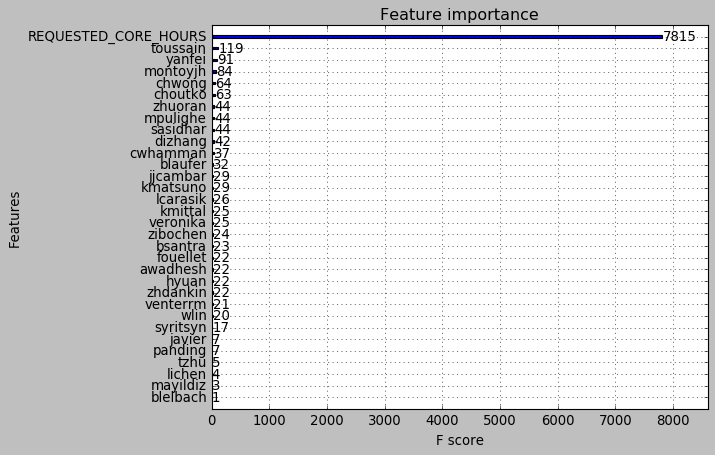

In [33]:
# xgb.plot_importance(xgb_model, importance_type='weight')

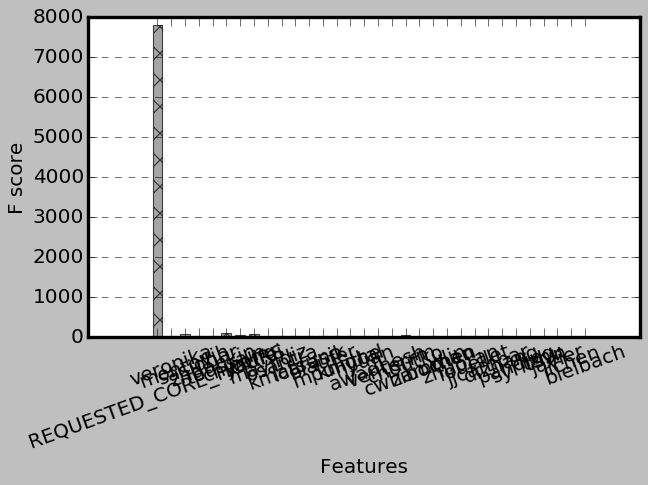

In [34]:
# def plot_feat_importance(imp, ofn=None):
#     ax = new_fig()
#     width = .7
#     plt.bar(range(len(imp)), imp.values(), align='center', 
#             width=width, color='gray', alpha=.7, hatch='x')
    
#     plt.xlabel('Features', fontsize=18)
#     plt.xticks(range(len(imp)), imp.keys(), rotation=20)
#     plt.ylabel('F score', fontsize=18)
#     if ofn is not None:
#         plt.savefig('figure/' + ofn, bbox_inches='tight')
        
# plot_feat_importance(xgb_model.get_booster().get_score(importance_type="weight"), )

In [35]:
# xgb_model.get_booster().get_score(importance_type="gain"), 

({'REQUESTED_CORE_HOURS': 0.17271648068034529,
  'veronika': 0.9364214132399996,
  'montoyjh': 2.141738814366583,
  'sasidhar': 3.506006667477274,
  'zhdankin': 9.446634261742728,
  'toussain': 2.8240545718252084,
  'chwong': 3.9049285486937495,
  'yanfei': 2.6203825246037464,
  'mayildiz': 0.3946318823333333,
  'bsantra': 3.909593056478261,
  'kmatsuno': 5.499421509000002,
  'lcarasik': 3.7194898993076935,
  'blaufer': 3.394613381343749,
  'mpulighe': 2.770932825481819,
  'kmittal': 3.1608595523600003,
  'hyuan': 3.9006381060909088,
  'awadhesh': 2.3785524049545455,
  'venterrm': 2.8748658655238097,
  'choutko': 1.262751602212222,
  'cwhamman': 1.8682953316351352,
  'zibochen': 2.33936263,
  'wlin': 2.7158400821499997,
  'zhuoran': 0.5588172419622729,
  'fouellet': 2.0351171400454544,
  'jjcambar': 0.9815800794482759,
  'dizhang': 0.7398731249142857,
  'panding': 0.7909239315714284,
  'syritsyn': 0.8575159049117648,
  'tzhu': 0.5251588108,
  'javier': 0.29574967300000005,
  'lichen': 

In [23]:
# exec_names = ('aims.180111.scalapack.mpi.x', 'lmp_mpi_7b', 'IOR', 'nek5000',
#               'ks_spectrum_hisq', 'aims.160328_3.scalapack.mpi.x', 'mcfm_omp', 'qlua',
#               'converge', 'vasp_gam', 'xmfdn-menj_BGQ-lan', 'project_dyn',
#               'qlua-bkend', 'distress', 'fs_verify.iomap', 'dns', 'fdl3di.exe',
#               'aims.071914_7.scalapack.mpi.x', 'goma', 'converge-2.4-mira-cat')

In [24]:
# def job_dist(fn, key, topn=20, ofn=None):
#     ntasks = pd.read_csv(fn)[key].value_counts().values
#     ntask_cnt = np.array(Counter(ntasks).most_common(topn))
#     print("%.2f%% jobs are covered by top %d" % (100.*ntask_cnt[:, 1].sum()/ntasks.shape[0], topn))
#     ax = new_fig()
#     plt.bar(range(ntask_cnt.shape[0]), 100.*ntask_cnt[:, 1]/ntasks.shape[0], \
#             width=.6, align='center', color='gray', hatch='x')
#     plt.ylabel('Percentage of Jobs', fontsize=22)
#     plt.xlabel('Number of tasks per job', fontsize=22)
#     plt.xticks(range(ntask_cnt.shape[0]), ['%d' % x for x in ntask_cnt[:,0]])
#     plt.xlim(left=-.5)
#     plt.ylim(top=99)
#     if ofn is not None:
#         plt.savefig('figure/' + ofn, bbox_inches='tight')
#     plt.show()
#     plt.close()
    
# for fn in sorted(glob.glob('data/ANL-ALCF-AUTOPERF-MIRA_*'))[1:2]:
# # for fn in sorted(glob.glob('datasets/autoperf/autoperf-*'))[:]:
#     print(fn)
#     job_dist(fn, key='PROC_BATCHJOBID', topn=10)
# #     job_dist(fn, key='zero_batchJobId', topn=10, ofn=fn.split('/')[-1][:-4]+'.pdf')

In [44]:
# _pdf = pd.read_csv('data/ANL-ALCF-AUTOPERF-MIRA_20160101_20161231.csv')
# topn = 10
# ntasks = _pdf.PROC_BATCHJOBID.value_counts().values
# ntask_cnt = np.array(Counter(ntasks).most_common(topn))

# print(ntasks.shape, _pdf.shape, _pdf.PROC_BATCHJOBID.unique().shape, ntasks.sum())

# _pdf[_pdf.PROC_BATCHJOBID == 770000].PROC_CSJOBID

FileNotFoundError: [Errno 2] File b'data/ANL-ALCF-AUTOPERF-MIRA_20160101_20161231.csv' does not exist: b'data/ANL-ALCF-AUTOPERF-MIRA_20160101_20161231.csv'